We start by importing our basic libraries.

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

2025-09-26 19:39:18.599768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758915558.965210      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758915559.069284      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Then, we analyze general information about our data set; how many images there are in total and how they are distributed across classes.

In [2]:
data="/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]"
counts=[]
folders = os.listdir(data)
print("The folders in this data set:",folders)

for folder in folders:
    count=len(os.listdir(os.path.join(data,folder)))
    counts.append(count)
    print(f"\n There are {count} images in this {folder}.")
print(f"\n There are {sum(counts)} images in Blood Cell Cancer data set.")

The folders in this data set: ['[Malignant] early Pre-B', '[Malignant] Pro-B', '[Malignant] Pre-B', 'Benign']

 There are 979 images in this [Malignant] early Pre-B.

 There are 796 images in this [Malignant] Pro-B.

 There are 955 images in this [Malignant] Pre-B.

 There are 512 images in this Benign.

 There are 3242 images in Blood Cell Cancer data set.


We then convert this information into a bar chart.

<function matplotlib.pyplot.show(close=None, block=None)>

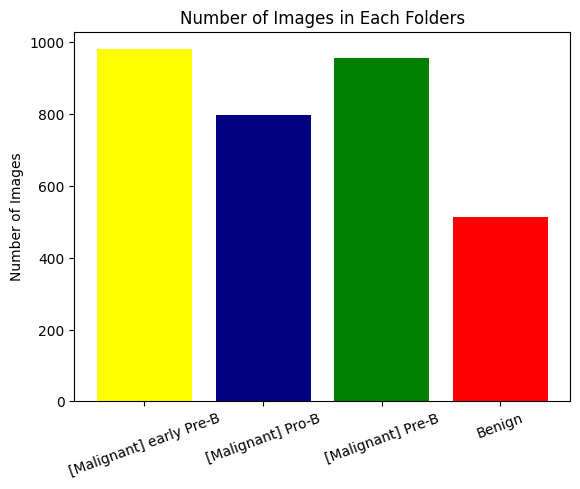

In [3]:
plt.bar(folders,counts, color=["yellow","navy","green","red"])
plt.title("Number of Images in Each Folders")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.show

To work more effectively with the data we are examining, we are getting one sample image from each data folder.

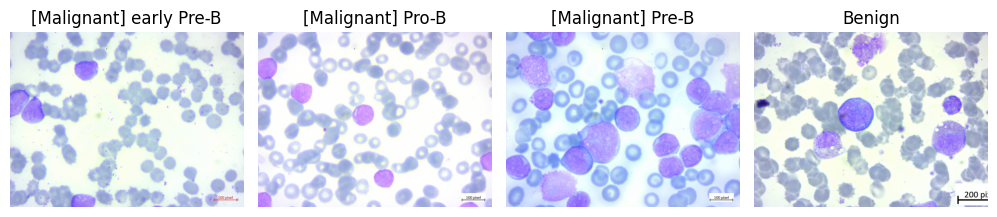

In [7]:
plt.figure(figsize=(20,10))

for i, f in enumerate(folders):
    img_file = random.choice(os.listdir(os.path.join(data, f)))
    img_path = os.path.join(data, f, img_file)
    img = mpimg.imread(img_path)

    plt.subplot(5,8,i+1)
    plt.imshow(img)
    plt.title(f)
    plt.axis("off")
plt.tight_layout()
plt.show()

We are adding features such as rotation, shift, and zoom here to enable our model to achive better results.(The purpose is to enable it to analyze an image better and make the most accurate selection.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=(150,150)
batch_size=32
image_gen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
    
)

train_gen=image_gen.flow_from_directory(
    "/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_gen=image_gen.flow_from_directory(
    "/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 2595 images belonging to 4 classes.
Found 647 images belonging to 4 classes.


Now, let's visualize and examine our data augmentation settings in an example.

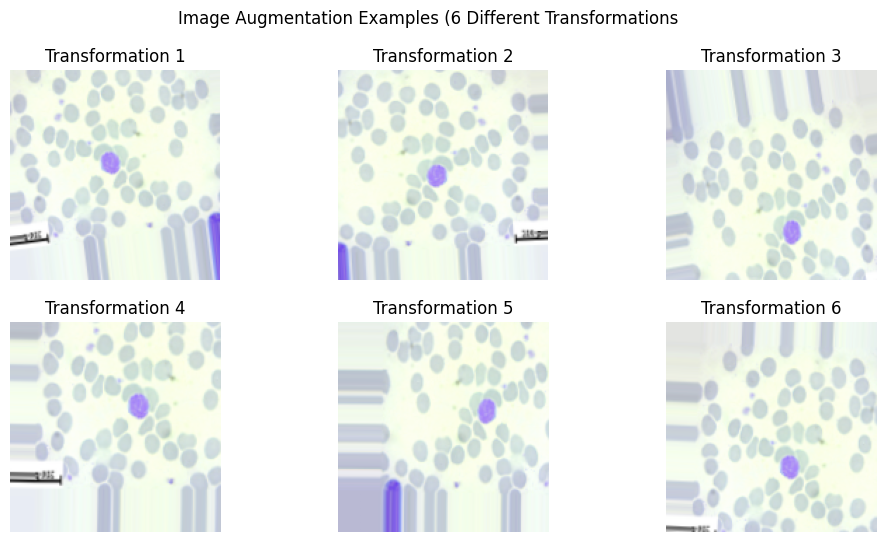

In [10]:
x_batch,y_batch =next(train_gen)
sample_img = x_batch[0]

plt.figure(figsize=(12,6))
plt.suptitle("Image Augmentation Examples (6 Different Transformations")

for i in range (6):
    augmented_img=image_gen.random_transform(sample_img)
    plt.subplot(2,3,i+1)
    plt.imshow(augmented_img)
    plt.title(f"Transformation {i+1}")
    plt.axis("off")
plt.show()
    

In [13]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

img_height, img_width=150,150
dropout_rate=0.4
learning_rate=0.001
num_clss=4

model=models.Sequential([
    layers.Conv2D(32,(3,3),input_shape=(img_height, img_width,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
  
    layers.Conv2D(64,(3,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128,(3,3)),
    BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(128,activation="relu"),
    layers.Dropout(dropout_rate),

    layers.Dense(64,activation="relu"),
    layers.Dropout(dropout_rate),

    layers.Dense(num_clss, activation="softmax")                    
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

early_stop=EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history=model.fit(
    train_gen,
    validation_data=validation_gen,
    epochs=25,
    callbacks=[early_stop]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,837,764 (18.45 MB)

 Trainable params: 4,837,316 (18.45 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25


I0000 00:00:1758915891.515366     118 service.cc:148] XLA service 0x7bfd40006160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758915891.516841     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758915891.516863     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758915892.179513     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/82 ━━━━━━━━━━━━━━━━━━━━ 16:22 12s/step - accuracy: 0.3125 - loss: 2.0240

I0000 00:00:1758915898.247683     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5613 - loss: 4.3432 - val_accuracy: 0.2457 - val_loss: 3.0030
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 592ms/step - accuracy: 0.7528 - loss: 0.7302 - val_accuracy: 0.4915 - val_loss: 1.5065
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 597ms/step - accuracy: 0.7653 - loss: 0.6980 - val_accuracy: 0.4807 - val_loss: 1.2940
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 589ms/step - accuracy: 0.7499 - loss: 0.7417 - val_accuracy: 0.3029 - val_loss: 1.7029
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 590ms/step - accuracy: 0.7396 - loss: 0.7126 - val_accuracy: 0.4142 - val_loss: 3.4421
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 593ms/step - accuracy: 0.7527 - loss: 0.6374 - val_accuracy: 0.1932 - val_loss: 6.6569
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 593ms/step - accuracy: 0.7642 - loss: 0.6283 - val_accuracy: 0.3400 - val_loss: 8.5588
Epoch 8/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 592ms/step - accuracy: 0.7656 - loss: 0.6053 - val_accuracy: 0.2952 

Let's transfer the Accuracy-Loss values obtained from our model to a line graph.

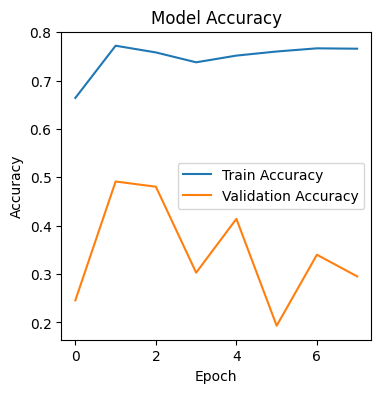

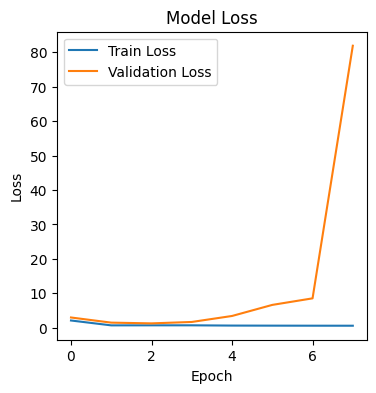

In [16]:
plt.figure(figsize=(4,4))
plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(4,4))
plt.plot(history.history["loss"],label="Train Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Our first experiment clearly demonstrated the model's tendency to overfit.

While Train Accuracy rapidly increased to over 75%, Validation Accuracy remained at around 30% and did not improve. This proves that the model successfully memorized the training data but failed to generalize to new images.

The Validation Loss value rapidly increased as Epochs progressed, reaching 81.9 levels, clearly revealing the severity of the overfitting problem. This dramatic increase was the basis for our transition to Dropout and Learning Rate optimizations.